# Insurance Fraud Detection – DS3000/DS9000 Project
**Goal:** Exploring Machine Learning Techniques for Insurance Fraud Detection



In [172]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import the dataset

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
df = pd.read_excel('Worksheet in Case Study question 2.xlsx', sheet_name=0)
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,NaN,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


## Inspect for missing values 

It is observed that the missing values are given by ? instead of null values.

In [174]:
# Replace ? with NaN
df=df.replace('?',np.nan)

df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,NaN,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,NaN,0,0,NaN,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,NaN,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,NaN,Minor Damage,NaN,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [175]:
df.isnull().sum()

months_as_customer               0
age                              0
policy_number                    0
policy_bind_date                 0
policy_state                     0
policy_csl                       0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_zip                      0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_hobbies                  0
insured_relationship             0
capital-gains                    0
capital-loss                     0
incident_date                    0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted           91
incident_state                   0
incident_city                    0
incident_location                0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                360
bodily_injuries     

In [176]:
# Fill null values with 'Unknown' since having a missing value carries information in this context
df['collision_type'] = df['collision_type'].fillna('Unknown')
df['property_damage'] = df['property_damage'].fillna('Unknown')
df['police_report_available'] = df['police_report_available'].fillna('Unknown')
df['authorities_contacted'] = df['authorities_contacted'].fillna('Unknown')

In [177]:
df.isnull().sum()

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

## Drop identifiers and free-text location fields (high-cardinality / leak risk)

In [178]:
drop_cols = [
        "policy_number", "policy_bind_date", "incident_date",
        "incident_location", "insured_zip"
    ]

for c in drop_cols:
    df = df.drop(columns=c)


## Check data types

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   object 
 3   policy_csl                   1000 non-null   object 
 4   policy_deductable            1000 non-null   int64  
 5   policy_annual_premium        1000 non-null   float64
 6   umbrella_limit               1000 non-null   int64  
 7   insured_sex                  1000 non-null   object 
 8   insured_education_level      1000 non-null   object 
 9   insured_occupation           1000 non-null   object 
 10  insured_hobbies              1000 non-null   object 
 11  insured_relationship         1000 non-null   object 
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

In [180]:
df.describe()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,1136.000000,1256.406150,1.101000e+06,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,611.864673,244.167395,2.297407e+06,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,500.000000,433.330000,-1.000000e+06,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,500.000000,1089.607500,0.000000e+00,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,1000.000000,1257.200000,0.000000e+00,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,2000.000000,1415.695000,0.000000e+00,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,2000.000000,2047.590000,1.000000e+07,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


In [181]:
fraud_reported = df['fraud_reported'].value_counts()
fraud_reported

fraud_reported
N    753
Y    247
Name: count, dtype: int64

We know that for 1000 observations, there were 247 cases of fraudulent data.

## Categorical Encoding

In [182]:
df.head(20)

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,Unknown,Minor Damage,Police,VA,Riverwood,8,1,Unknown,0,0,Unknown,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,Unknown,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,Unknown,Minor Damage,Unknown,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
5,256,39,OH,250/500,1000,1351.10,0,FEMALE,PhD,tech-support,bungie-jumping,unmarried,0,0,Multi-vehicle Collision,Rear Collision,Major Damage,Fire,SC,Arlington,19,3,NO,0,2,NO,64100,6410,6410,51280,Saab,95,2003,Y
6,137,34,IN,250/500,1000,1333.35,0,MALE,PhD,prof-specialty,board-games,husband,0,-77000,Multi-vehicle Collision,Front Collision,Minor Damage,Police,NY,Springfield,0,3,Unknown,0,0,Unknown,78650,21450,7150,50050,Nissan,Pathfinder,2012,N
7,165,37,IL,100/300,1000,1137.03,0,MALE,Associate,tech-support,base-jumping,unmarried,0,0,Multi-vehicle Collision,Front Collision,Total Loss,Police,VA,Columbus,23,3,Unknown,2,2,YES,51590,9380,9380,32830,Audi,A5,2015,N
8,27,33,IL,100/300,500,1442.99,0,FEMALE,PhD,other-service,golf,own-child,0,0,Single Vehicle Collision,Front Collision,Total Loss,Police,WV,Arlington,21,1,NO,1,1,YES,27700,2770,2770,22160,Toyota,Camry,2012,N
9,212,42,IL,100/300,500,1315.68,0,MALE,PhD,priv-house-serv,camping,wife,0,-39300,Single Vehicle Collision,Rear Collision,Total Loss,Other,NC,Hillsdale,14,1,NO,2,1,Unknown,42300,4700,4700,32900,Saab,92x,1996,N


In [183]:
from sklearn.preprocessing import LabelEncoder

# Encode all categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include='object'):
    df[col] = le.fit_transform(df[col].astype(str))

df.head(20)

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,2,1,1000,1406.91,0,1,4,2,17,0,53300,0,2,2,0,3,4,1,5,1,2,1,2,2,71610,6510,13020,52080,10,1,2004,1
1,228,42,1,1,2000,1197.22,5000000,1,4,6,15,2,0,0,3,3,1,3,5,5,8,1,1,0,0,1,5070,780,780,3510,8,12,2007,1
2,134,29,2,0,2000,1413.14,5000000,0,6,11,2,3,35100,0,0,1,1,3,1,1,7,3,0,2,3,0,34650,7700,3850,23100,4,30,2007,0
3,256,41,0,1,2000,1415.74,6000000,0,6,1,2,4,48900,-62400,2,0,0,3,2,0,5,1,1,1,2,0,63400,6340,6340,50720,3,34,2014,1
4,228,44,0,2,1000,1583.91,6000000,1,0,11,2,4,66000,-46000,3,3,1,4,1,0,20,1,0,0,1,0,6500,1300,650,4550,0,31,2009,0
5,256,39,2,1,1000,1351.10,0,0,6,12,3,4,0,0,0,1,0,1,4,0,19,3,0,0,2,0,64100,6410,6410,51280,10,3,2003,1
6,137,34,1,1,1000,1333.35,0,1,6,9,2,0,0,-77000,0,0,1,3,1,6,0,3,1,0,0,1,78650,21450,7150,50050,9,29,2012,0
7,165,37,0,0,1000,1137.03,0,1,0,12,0,4,0,0,0,0,2,3,5,1,23,3,1,2,2,2,51590,9380,9380,32830,1,5,2015,0
8,27,33,0,0,500,1442.99,0,0,6,7,9,3,0,0,2,0,2,3,6,0,21,1,0,1,1,2,27700,2770,2770,22160,12,9,2012,0
9,212,42,0,0,500,1315.68,0,1,6,8,4,5,0,-39300,2,1,2,2,0,2,14,1,0,2,1,1,42300,4700,4700,32900,10,1,1996,0


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   int64  
 3   policy_csl                   1000 non-null   int64  
 4   policy_deductable            1000 non-null   int64  
 5   policy_annual_premium        1000 non-null   float64
 6   umbrella_limit               1000 non-null   int64  
 7   insured_sex                  1000 non-null   int64  
 8   insured_education_level      1000 non-null   int64  
 9   insured_occupation           1000 non-null   int64  
 10  insured_hobbies              1000 non-null   int64  
 11  insured_relationship         1000 non-null   int64  
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

## Look at distribution and correlation

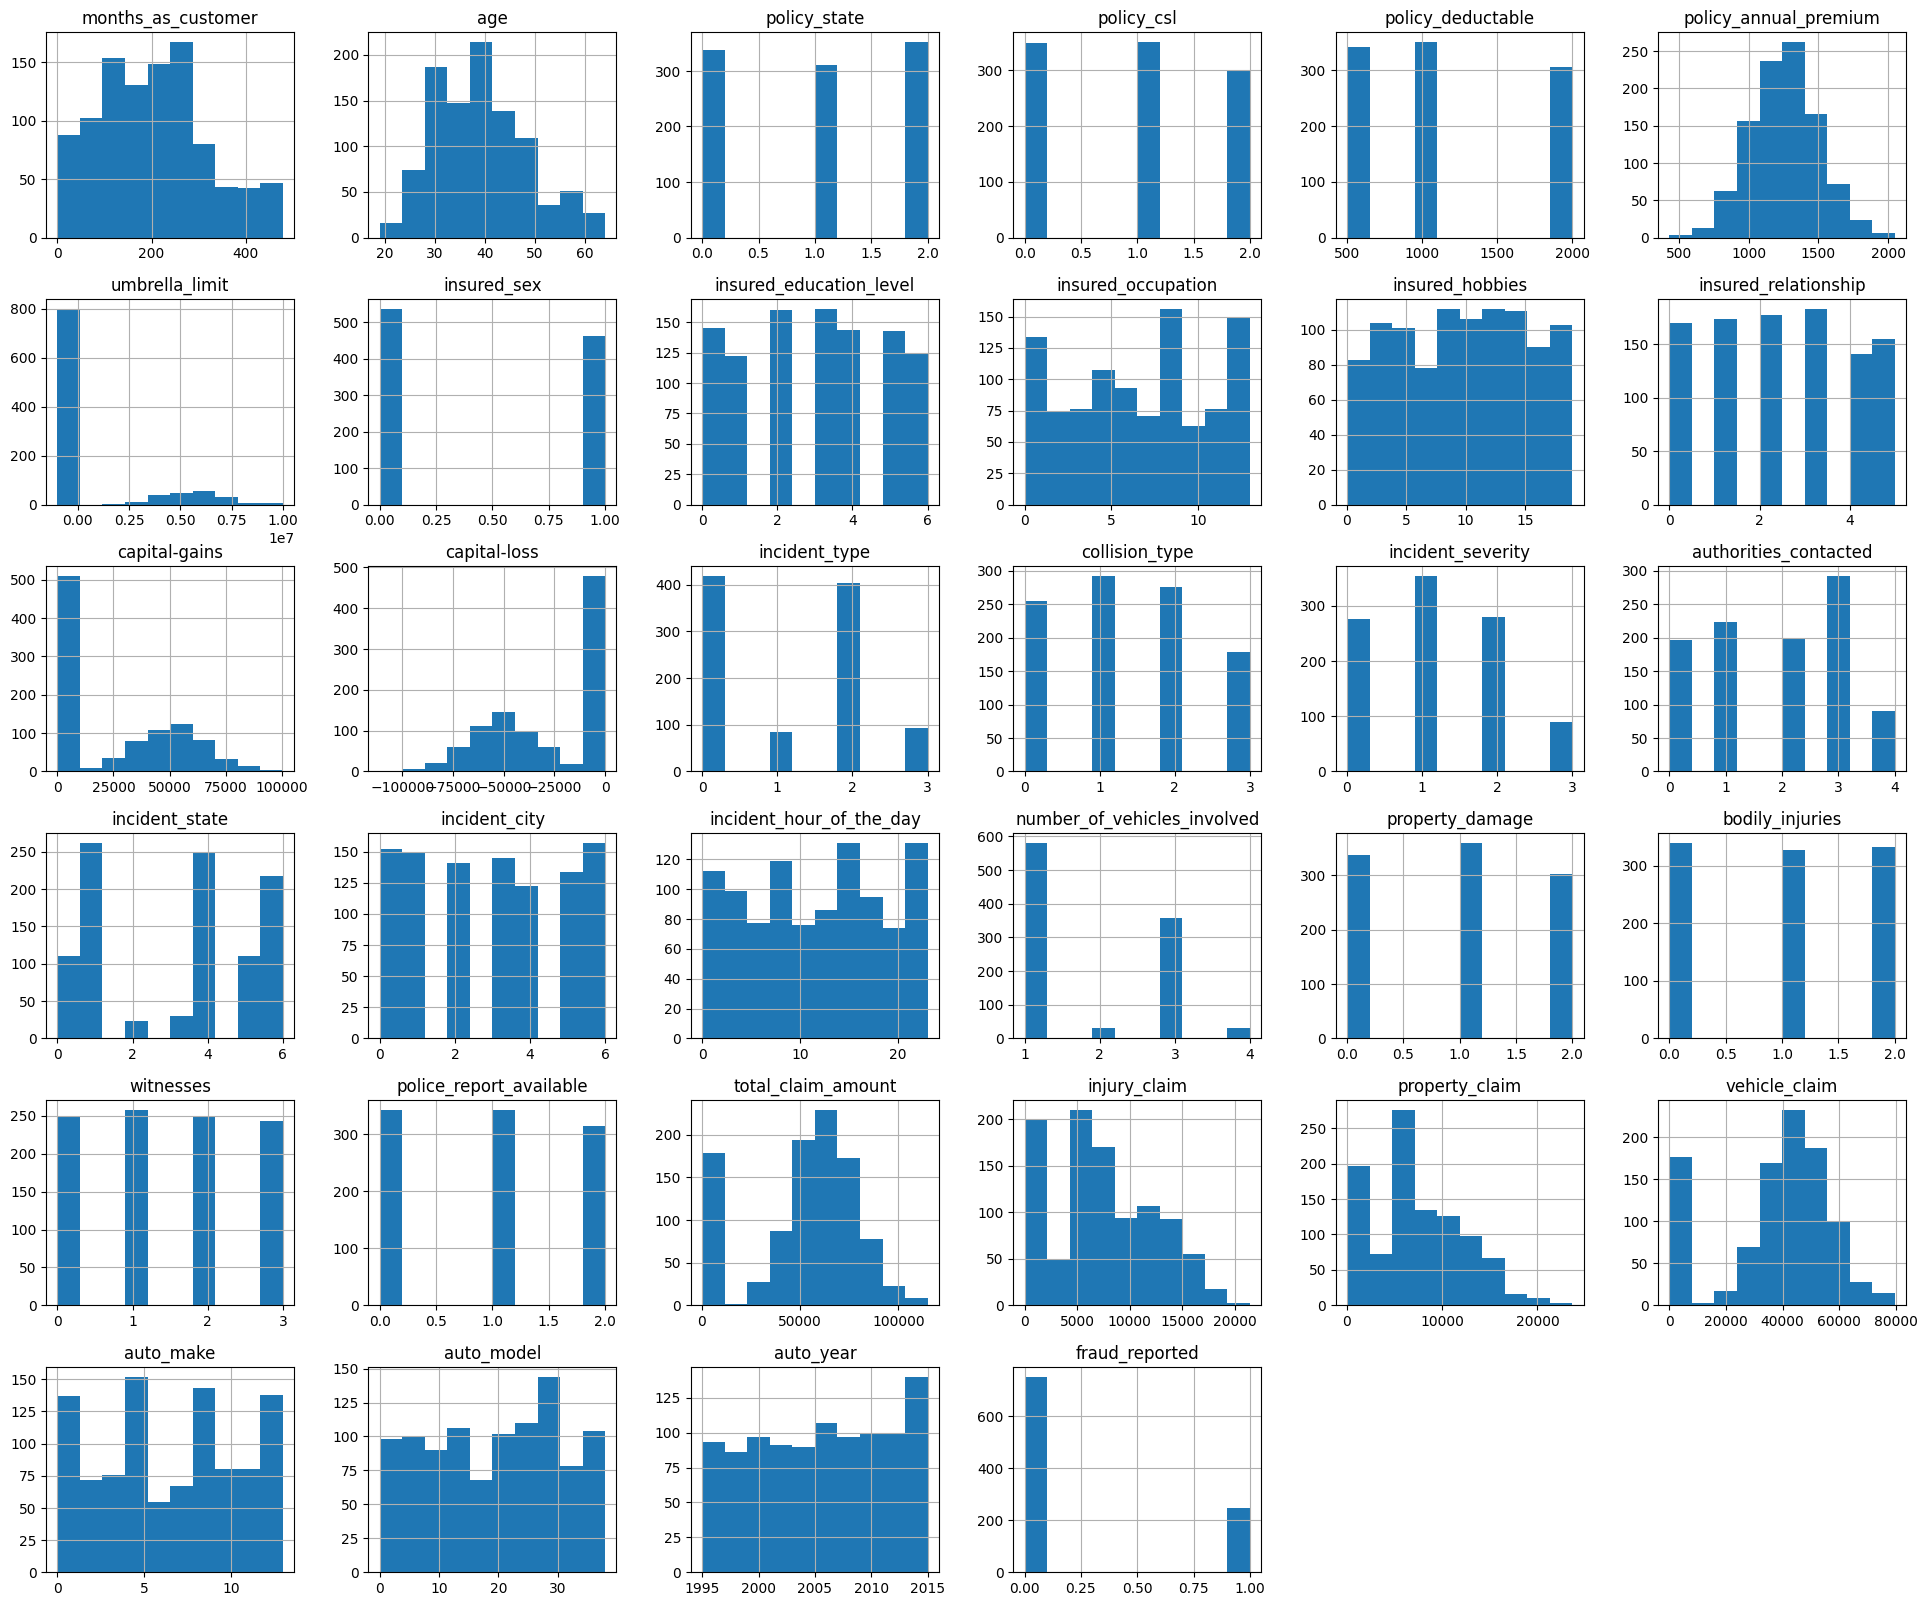

In [185]:
import seaborn as sns
df.hist(figsize=(24, 20))

for col in df:
    sns.histplot(df[col], kde=True)


<Axes: >

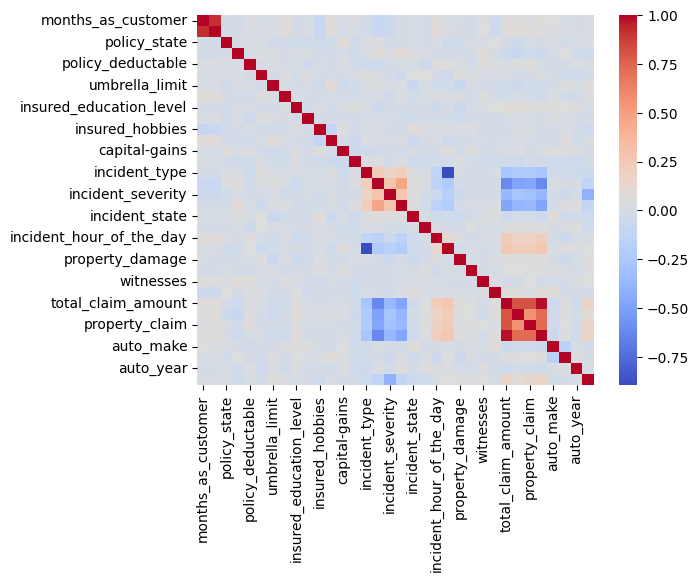

In [186]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=False)

## Split features and target

In [187]:
X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported']

X.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year
0,328,48,2,1,1000,1406.91,0,1,4,2,17,0,53300,0,2,2,0,3,4,1,5,1,2,1,2,2,71610,6510,13020,52080,10,1,2004
1,228,42,1,1,2000,1197.22,5000000,1,4,6,15,2,0,0,3,3,1,3,5,5,8,1,1,0,0,1,5070,780,780,3510,8,12,2007
2,134,29,2,0,2000,1413.14,5000000,0,6,11,2,3,35100,0,0,1,1,3,1,1,7,3,0,2,3,0,34650,7700,3850,23100,4,30,2007
3,256,41,0,1,2000,1415.74,6000000,0,6,1,2,4,48900,-62400,2,0,0,3,2,0,5,1,1,1,2,0,63400,6340,6340,50720,3,34,2014
4,228,44,0,2,1000,1583.91,6000000,1,0,11,2,4,66000,-46000,3,3,1,4,1,0,20,1,0,0,1,0,6500,1300,650,4550,0,31,2009


In [188]:
y.head()

0    1
1    1
2    0
3    1
4    0
Name: fraud_reported, dtype: int64

### Train/test split

In [189]:
# Do a train/test split but with validation, since we will be tuning hyperparameters
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val) 

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(y_train.value_counts(), y_val.value_counts(), y_test.value_counts())
print(y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True))

(600, 33) (200, 33) (200, 33)
(600,) (200,) (200,)
fraud_reported
0    451
1    149
Name: count, dtype: int64 fraud_reported
0    151
1     49
Name: count, dtype: int64 fraud_reported
0    151
1     49
Name: count, dtype: int64
fraud_reported
0    0.751667
1    0.248333
Name: proportion, dtype: float64 fraud_reported
0    0.755
1    0.245
Name: proportion, dtype: float64 fraud_reported
0    0.755
1    0.245
Name: proportion, dtype: float64


## Build imputers and scalers

In [190]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Imputers / scalers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_cols)], remainder="drop")

In [191]:
preprocessor

,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None
